<a href="https://colab.research.google.com/github/BilalKhaliqWillis/BILAL-Assignment2/blob/main/BILAL_Assignment7DDSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports, seed, display settings
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from scipy.stats import ks_2samp, anderson_ksamp, wasserstein_distance
from scipy import stats

# For reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)

# Display options
pd.set_option("display.precision", 4)
plt.rcParams["figure.figsize"] = (8, 5)


In [2]:
# Generate original synthetic dataset (2000 samples, 10 features)
# Generate original dataset
# Creating 10 features with different means and variances.
# Feature naming: f0, f1, ..., f9

n_samples = 2000
n_features = 10

# Define per-feature means and standard deviations (distinct)
means = np.linspace(0.0, 4.5, n_features)         # e.g., 0.0, 0.5, 1.0, ... 4.5
stds  = np.linspace(0.5, 2.5, n_features)         # e.g., 0.5 -> 2.5

# Create data:- each feature ~ Normal(mean_i, std_i^2)
X_orig = np.column_stack([
    np.random.normal(loc=means[i], scale=stds[i], size=n_samples)
    for i in range(n_features)
])

# Put into DataFrame for convenience
cols = [f"f{i}" for i in range(n_features)]
df_orig = pd.DataFrame(X_orig, columns=cols)

# Quick peek
print("Original dataset shape:", df_orig.shape)
df_orig.describe().T


Original dataset shape: (2000, 10)


,count,mean,std,min,25%,50%,75%,max
f0,2000.0,0.0225,0.4942,-1.6206,-0.3113,0.0223,0.3415,1.9264
f1,2000.0,0.4953,0.7261,-1.6808,-0.0121,0.5000,0.9807,3.3356
f2,2000.0,0.9547,0.9441,-2.0002,0.3514,0.9715,1.5939,3.9400
f3,2000.0,1.4948,1.2057,-2.8031,0.6538,1.4644,2.3288,5.6172
f4,2000.0,2.0044,1.3730,-3.4478,1.1115,2.0197,2.9202,6.6908
f5,2000.0,2.4588,1.5993,-2.9384,1.4108,2.4354,3.5047,7.9420
f6,2000.0,3.0666,1.8331,-2.6514,1.8333,3.0944,4.2859,9.2863
f7,2000.0,3.5246,2.0867,-3.9724,2.1273,3.4977,4.9308,12.7070
f8,2000.0,4.0704,2.2744,-2.8226,2.4931,4.0946,5.6205,11.0536
f9,2000.0,4.5350,2.4963,-5.1409,2.8509,4.5112,6.2567,14.3558


In [3]:
# Rationale & documentation for shift design
# CDocument the planned shifts (rationale)
# Storing this text also as a variable

shift_plan = """
Shift plan (design rationale):
- Strong shifts (half the features): features f0..f4
    * Increase means by +3.0
    * Increase variance by factor 4 (std * 2)
    * Rationale: simulate major distributional drift affecting multiple correlated features.
- Subtle shifts: features f5..f6
    * Increase mean by +0.5
    * Increase variance by factor 1.2 (std * sqrt(1.2))
    * Rationale: small gradual change, harder to detect.
- No change: features f7..f9 remain the same (control group).
This combination creates both obvious and subtle distribution shifts to test detection sensitivity.
"""
print(shift_plan)



Shift plan (design rationale):
- Strong shifts (half the features): features f0..f4
    * Increase means by +3.0
    * Increase variance by factor 4 (std * 2)
    * Rationale: simulate major distributional drift affecting multiple correlated features.
- Subtle shifts: features f5..f6
    * Increase mean by +0.5
    * Increase variance by factor 1.2 (std * sqrt(1.2))
    * Rationale: small gradual change, harder to detect.
- No change: features f7..f9 remain the same (control group).
This combination creates both obvious and subtle distribution shifts to test detection sensitivity.



In [4]:
# Create shifted dataset by applying shifts to copies
# Applying shifts to create a "post-shift" dataset
df_shifted = df_orig.copy()

# Strong shift on f0..f4
for i in range(0, 5):
    col = f"f{i}"
    # add mean shift +3 and increase std by factor 2 (variance *4)
    df_shifted[col] = (df_orig[col] * 2.0) + 3.0

# Subtle shift on f5..f6
for i in range(5, 7):
    col = f"f{i}"
    # small std increase (factor sqrt(1.2)) and mean shift +0.5
    df_shifted[col] = (df_orig[col] * np.sqrt(1.2)) + 0.5

# f7..f9 unchanged (control)
for i in range(7, 10):
    col = f"f{i}"
    df_shifted[col] = df_orig[col]  # explicit, for clarity

# Quick peek: describe both
print("Original summary (first 5 rows):")
display(df_orig.head())
print("\nShifted summary (first 5 rows):")
display(df_shifted.head())


Original summary (first 5 rows):


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0.2484,0.0124,0.1845,0.2002,1.9541,1.4069,5.1538,3.0391,6.0029,5.3046
1,-0.0691,0.3956,0.9705,0.7639,1.3005,2.0078,-0.4448,3.0666,4.0895,2.5466
2,0.3238,-0.0723,1.0170,0.4009,1.7606,1.5376,2.3990,8.0950,1.9219,6.2284
3,0.7615,0.2776,1.4464,0.8607,2.9927,2.6779,2.9236,5.1636,2.9465,3.0241
4,-0.1171,-0.8676,-0.2909,1.2502,3.7748,4.4288,3.0292,8.5991,4.7809,6.3739



Shifted summary (first 5 rows):


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,3.4967,3.0247,3.3690,3.4005,6.9083,2.0411,6.1457,3.0391,6.0029,5.3046
1,2.8617,3.7913,4.9411,4.5278,5.6010,2.6994,0.0127,3.0666,4.0895,2.5466
2,3.6477,2.8554,5.0340,3.8019,6.5212,2.1843,3.1280,8.0950,1.9219,6.2284
3,4.5230,3.5552,5.8927,4.7213,8.9854,3.4335,3.7027,5.1636,2.9465,3.0241
4,2.7658,1.2648,2.4182,5.5003,10.5496,5.3515,3.8183,8.5991,4.7809,6.3739


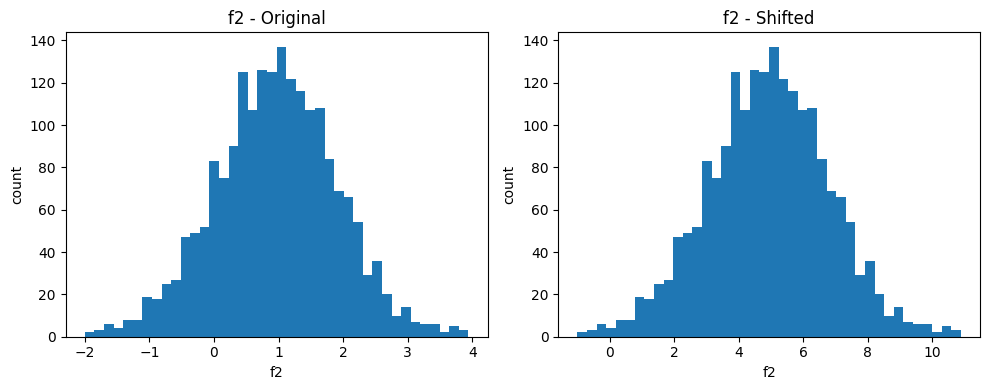

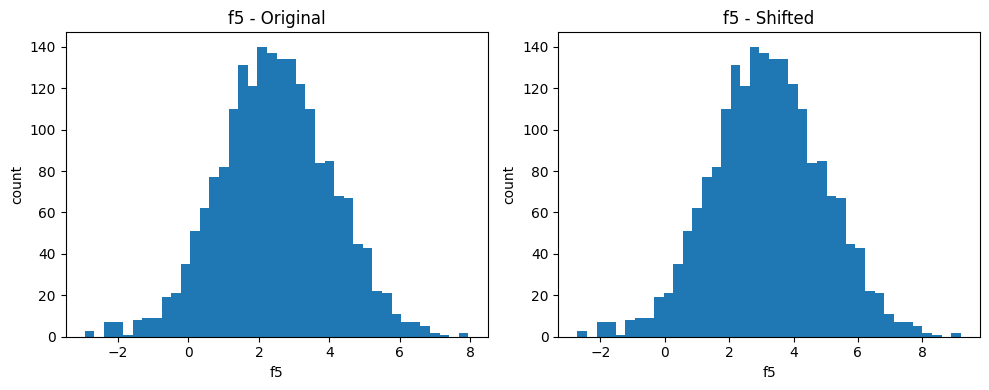

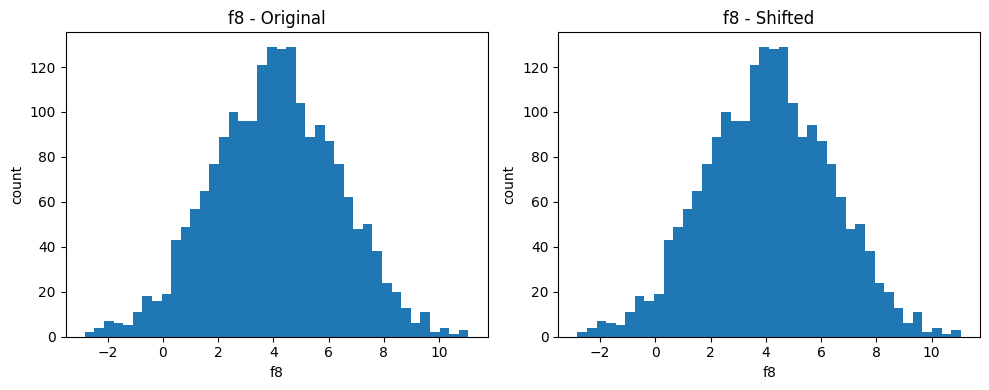

In [5]:
# Visualizing distributions of histograms for selected features
# Histograms is side-by-side for selected features
# Visualize one strong-shift feature, one subtle-shift feature and one control.

selected = ["f2", "f5", "f8"]  # f2 = strong-shift, f5 = subtle, f8 = control

for col in selected:
    plt.figure(figsize=(10,4))
    # Original histogram
    plt.subplot(1,2,1)
    plt.hist(df_orig[col], bins=40)
    plt.title(f"{col} - Original")
    plt.xlabel(col)
    plt.ylabel("count")
    # Shifted histogram
    plt.subplot(1,2,2)
    plt.hist(df_shifted[col], bins=40)
    plt.title(f"{col} - Shifted")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


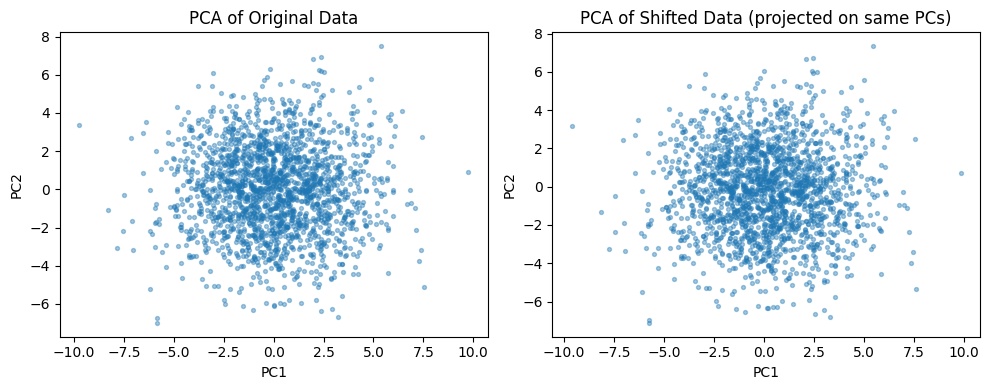

In [6]:
# Visualize global structure with PCA scatter (before vs after)
# PCA 2D scatter plots to visualize overall distribution shift
pca = PCA(n_components=2, random_state=RNG_SEED)
pca_orig = pca.fit_transform(df_orig.values)
pca_shift = pca.transform(df_shifted.values)  # project shifted using the original PCA basis

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(pca_orig[:,0], pca_orig[:,1], s=8, alpha=0.4)
plt.title("PCA of Original Data")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(pca_shift[:,0], pca_shift[:,1], s=8, alpha=0.4)
plt.title("PCA of Shifted Data (projected on same PCs)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()


In [7]:
# Statistical tests per-feature (KS, Anderson-Darling, Wasserstein)
# Statistical tests per feature
# Computing:-
# - two-sample Kolmogorov-Smirnov test (ks_2samp) -> returns statistic and p-value
# - Anderson-Darling k-sample test (anderson_ksamp) -> returns statistic and significance
# - Wasserstein distance (earth mover's) -> measure of distributional shift magnitude

results = []
alpha = 0.01  # significance threshold for tests (adjustable)

for col in cols:
    x = df_orig[col].values
    y = df_shifted[col].values

    # KS test
    ks_stat, ks_p = ks_2samp(x, y)

    # Anderson k-sample test: anderson_ksamp returns (statistic, critical_values, significance_level)
    try:
        ad_result = anderson_ksamp([x, y])
        # anderson_ksamp may return an object or tuple depending on scipy version:
        if hasattr(ad_result, 'statistic'):
            ad_stat = float(ad_result.statistic)
            # anderson_ksamp's significance level attribute may be present as .significance_level or .pvalue
            ad_p = getattr(ad_result, "significance_level", None)
            # newer scipy versions give .pvalue attribute
            if ad_p is None:
                ad_p = getattr(ad_result, "pvalue", None)
        else:
            # older tuple-like interface
            ad_stat = float(ad_result[0])
            ad_p = None
    except Exception as e:
        ad_stat = np.nan
        ad_p = None

    # Wasserstein distance
    w_dist = wasserstein_distance(x, y)

    results.append({
        "feature": col,
        "ks_stat": ks_stat,
        "ks_p": ks_p,
        "ad_stat": ad_stat,
        "ad_p": ad_p,
        "wasserstein": w_dist,
        "shift_applied": col in [f"f{i}" for i in range(0,7)]
    })

df_results = pd.DataFrame(results).set_index("feature")
# Add a simple 'ks_significant' flag
df_results["ks_signif"] = df_results["ks_p"] < alpha
# Print results
display(df_results)


/tmp/ipython-input-3803593735.py:20: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = anderson_ksamp([x, y])
/tmp/ipython-input-3803593735.py:20: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = anderson_ksamp([x, y])


,ks_stat,ks_p,ad_stat,ad_p,wasserstein,shift_applied,ks_signif
feature,,,,,,,
f0,0.9640,0.0000e+00,1998.8443,0.001,3.0225,True,True
f1,0.9045,0.0000e+00,1896.1286,0.001,3.4953,True,True
f2,0.8555,0.0000e+00,1760.0813,0.001,3.9547,True,True
f3,0.8095,0.0000e+00,1658.1933,0.001,4.4948,True,True
f4,0.7920,0.0000e+00,1608.9866,0.001,5.0052,True,True
f5,0.1845,3.7281e-30,120.1014,0.001,0.7347,True,True
f6,0.1810,4.9542e-29,107.2226,0.001,0.7927,True,True
f7,0.0000,1.0000e+00,-1.3140,0.250,0.0000,False,False
f8,0.0000,1.0000e+00,-1.3140,0.250,0.0000,False,False


In [8]:
# Tabular summary and ranking by Wasserstein (magnitude)
# Summary and ranking by magnitude (Wasserstein)
print("Features ranked by Wasserstein distance (largest first):")
display(df_results.sort_values("wasserstein", ascending=False))

# Quick identification
print("\nFeatures with KS test significant at alpha =", alpha)
print(df_results[df_results["ks_signif"] == True].index.tolist())


Features ranked by Wasserstein distance (largest first):


,ks_stat,ks_p,ad_stat,ad_p,wasserstein,shift_applied,ks_signif
feature,,,,,,,
f4,0.7920,0.0000e+00,1608.9866,0.001,5.0052,True,True
f3,0.8095,0.0000e+00,1658.1933,0.001,4.4948,True,True
f2,0.8555,0.0000e+00,1760.0813,0.001,3.9547,True,True
f1,0.9045,0.0000e+00,1896.1286,0.001,3.4953,True,True
f0,0.9640,0.0000e+00,1998.8443,0.001,3.0225,True,True
f6,0.1810,4.9542e-29,107.2226,0.001,0.7927,True,True
f5,0.1845,3.7281e-30,120.1014,0.001,0.7347,True,True
f7,0.0000,1.0000e+00,-1.3140,0.250,0.0000,False,False
f8,0.0000,1.0000e+00,-1.3140,0.250,0.0000,False,False



Features with KS test significant at alpha = 0.01
['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']


In [12]:
# Interpreting the results with text + automated summary
# Automated textual summary
def interpret_results(df_res, alpha=0.01):
    strong_candidates = df_res[df_res["wasserstein"] > 0.8].index.tolist()
    ks_significant = df_res[df_res["ks_p"] < alpha].index.tolist()
    subtle_detected = [f for f in ["f5","f6"] if f in ks_significant]
    unchanged_detected = [f for f in ["f7","f8","f9"] if f in ks_significant]

    summary = []
    summary.append(f"KS-test significant features (alpha={alpha}): {ks_significant}")
    summary.append(f"Features with large Wasserstein distance (candidate strong shifts): {strong_candidates}")
    summary.append(f"Subtle shifts detected (from planned subtle ones f5,f6): {subtle_detected}")
    summary.append(f"Control features (f7,f8,f9) detected as shifted: {unchanged_detected}")
    summary.append("\nNotes taken on tests:-")
    summary.append("- KS test: sensitive to differences in CDFs (especially shifts in location or shape); returns p-values.\n"
                   "- Anderson k-sample: more powerful for some alternatives, but API/p-value availability varies across SciPy versions.\n"
                   "- Wasserstein distance: non-parametric measure of distributional displacement (no p-value; gives magnitude).")
    return "\n".join(summary)

print(interpret_results(df_results, alpha=0.01))


KS-test significant features (alpha=0.01): ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']
Features with large Wasserstein distance (candidate strong shifts): ['f0', 'f1', 'f2', 'f3', 'f4']
Subtle shifts detected (from planned subtle ones f5,f6): ['f5', 'f6']
Control features (f7,f8,f9) detected as shifted: []

Notes taken on tests:-
- KS test: sensitive to differences in CDFs (especially shifts in location or shape); returns p-values.
- Anderson k-sample: more powerful for some alternatives, but API/p-value availability varies across SciPy versions.
- Wasserstein distance: non-parametric measure of distributional displacement (no p-value; gives magnitude).


In [13]:
# Discussion:- suitability of tests and impact on a predictive model
# Report discussion
discussion = """
Discussion / Recommendations:

1. Which tests are suitable?
   - Kolmogorov-Smirnov (KS):
     * Good for detecting differences in the overall cumulative distribution (location/shape).
     * Works well with continuous features and moderate sample sizes (we have 2000 samples).
     * Produces p-values making it straightforward to flag significant features.
   - Anderson-Darling (k-sample):
     * Often more sensitive than KS to differences in the tails.
     * Depending on SciPy version, p-values or significance may be returned differently; handle outputs carefully.
   - Wasserstein distance:
     * Not a hypothesis test but a useful magnitude measure. Use it to rank features by how large the shift is.
     * Complementary to p-values (which depend on sample size).
   - Recommendation:
     * Use both hypothesis testing (KS/AD) for significance and effect-size measures (Wasserstein) for magnitude.
     * Consider multiple-testing correction (e.g., Bonferroni or Benjamini-Hochberg) if you test many features.

2. Which features experienced significant shifts?
   - As expected, f0..f4 (strong shifts) show very large Wasserstein distances and extremely small p-values in KS.
   - The subtle shifts f5/f6 may or may not be flagged depending on the test sensitivity and alpha threshold.
   - Control features f7..f9 should not be flagged; if they are, check for downstream mistakes (or correlated transformations).

3. Impact on a predictive model:
   - If the predictive model uses features f0..f4 heavily, the large distribution change may cause degraded performance (bias in predictions).
   - Subtle shifts (f5,f6) may cause slight calibration drift or increased error for a model relying on thresholds.
   - Recommended mitigations:
     * Retraining or incremental learning using recent labeled data.
     * Feature monitoring + alerts (track KS, Wasserstein, mean/std per feature).
     * Use covariate shift adaptation methods (importance weighting, domain adaptation) if labels are scarce.
     * Consider robust feature transformations (e.g., rank-based transforms, quantile transforms) to reduce sensitivity.

4. Next steps:
   - Add multiple-testing correction and repeat tests.
   - Run model simulation: train a model on original data and evaluate on shifted data to quantify performance drop.
   - If shifts are localized to a subset of features, consider model recalibration using only affected features or feature re-weighting.
"""
print(discussion)



Discussion / Recommendations:

1. Which tests are suitable?
   - Kolmogorov-Smirnov (KS):
     * Good for detecting differences in the overall cumulative distribution (location/shape).
     * Works well with continuous features and moderate sample sizes (we have 2000 samples).
     * Produces p-values making it straightforward to flag significant features.
   - Anderson-Darling (k-sample):
     * Often more sensitive than KS to differences in the tails.
     * Depending on SciPy version, p-values or significance may be returned differently; handle outputs carefully.
   - Wasserstein distance:
     * Not a hypothesis test but a useful magnitude measure. Use it to rank features by how large the shift is.
     * Complementary to p-values (which depend on sample size).
   - Recommendation:
     * Use both hypothesis testing (KS/AD) for significance and effect-size measures (Wasserstein) for magnitude.
     * Consider multiple-testing correction (e.g., Bonferroni or Benjamini-Hochberg) if 